# The code here is modified from the code on Jason Brownlee's website:
https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

In [51]:
import math
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import statsmodels as sm
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

from numpy import split
from numpy import array
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from keras.models import load_model
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


Import data and preprocessing

In [2]:
df = pd.read_excel("AirQualityUCI.xlsx",parse_dates=[['Date', 'Time']])
df['Date_Time'] = pd.to_datetime(df.Date_Time , format = '%d/%m/%Y %H.%M.%S')
data = df.drop(['Date_Time'], axis=1)
data.index = df.Date_Time
Frame = pd.DataFrame(data,columns=['CO(GT)','PT08.S1(CO)','C6H6(GT)'])
for row in list(Frame):
    for index,row_d in df.iterrows():
        if(Frame[row][index] == -200):
            m=1
            while(Frame[row][index+m] == -200):
                m+=1
            Frame[row][index] = (Frame[row][index-1]+Frame[row][index+m])/2

In [3]:
print(Frame.describe())

            CO(GT)  PT08.S1(CO)     C6H6(GT)
count  9357.000000  9357.000000  9357.000000
mean      2.178455  1103.259106    10.167384
std       1.465475   219.803612     7.524724
min       0.100000   647.250000     0.149048
25%       1.000000   936.750000     4.439302
50%       1.900000  1068.750000     8.301413
75%       3.000000  1241.250000    14.266928
max      11.900000  2039.750000    63.741476


In [102]:
# split a univariate dataset into train/test sets
def split_dataset(data,time_step,proportion = 0.8,diff = False):
    first = []
    # split into standard weeks
    if diff:
        first = data.iloc[0]
        data = data.diff(1)
        data.dropna(inplace = True)
        data = data.values
    else:
        data = data.values
    size = math.floor((len(data)*proportion)/time_step)
    size_rest = math.floor((len(data)-size*time_step)/time_step)
    train, test = data[0:size*time_step], data[size*time_step:(size+size_rest)*time_step]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/time_step))
    test = array(split(test, len(test)/time_step))
    print("Train and test set have %d and %d stardard units" % (size,size_rest))
    return train,test,first

In [5]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = math.sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = math.sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [6]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_output,num):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_output
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, num])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [7]:
# train the model
def build_model(train, n_input, n_output, num):
	# prepare data
	train_x, train_y = to_supervised(train, n_input,n_output,num)
	# define parameters
	verbose, epochs, batch_size = 0, 50, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [8]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [9]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

Use all data to fit model

In [114]:
n_input = 12
n_output = 12
want_predict_num = 1

# split into train and test
train, test ,first= split_dataset(Frame,n_input)
# evaluate model and get scores

Train and test set have 623 and 156 stardard units


In [115]:
print(train.shape)

(623, 12, 3)


In [116]:
# fit model
model = build_model(train, n_input, n_output, want_predict_num)
#model.save("D://Model/Multivariate multi-step encoder-decoder-var2-6ts LSTM.h5")

In [117]:
# history is a list of weekly data
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict the week
    yhat_sequence = forecast(model, history, n_input)#last 12h data was used to predict future(first 12h in test set)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)

In [118]:
score, scores = evaluate_forecasts(test[:, :, want_predict_num], predictions)

lstm: [139.252] 76.7, 126.8, 167.7, 167.9, 145.1, 130.8, 136.3, 135.0, 131.9, 137.1, 146.0, 148.1


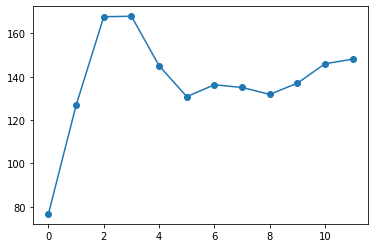

In [119]:
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = list(range(len(scores)))
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

In [120]:
plot_predictions = predictions.reshape(predictions.shape[0]*predictions.shape[1],1)
plot_ground_truth = test[:, :, want_predict_num].reshape(test.shape[0]*test.shape[1],1)

Future Data, Accuracy can be assessed by the RMSE coefficient shown below

In [121]:
y_future = forecast(model,history,n_input)
print(y_future)

[[ 965.43567]
 [1098.5026 ]
 [1158.1249 ]
 [1176.254  ]
 [1145.4547 ]
 [1112.3065 ]
 [1088.7565 ]
 [1080.5765 ]
 [1084.031  ]
 [1095.9288 ]
 [1110.756  ]
 [1126.1884 ]]


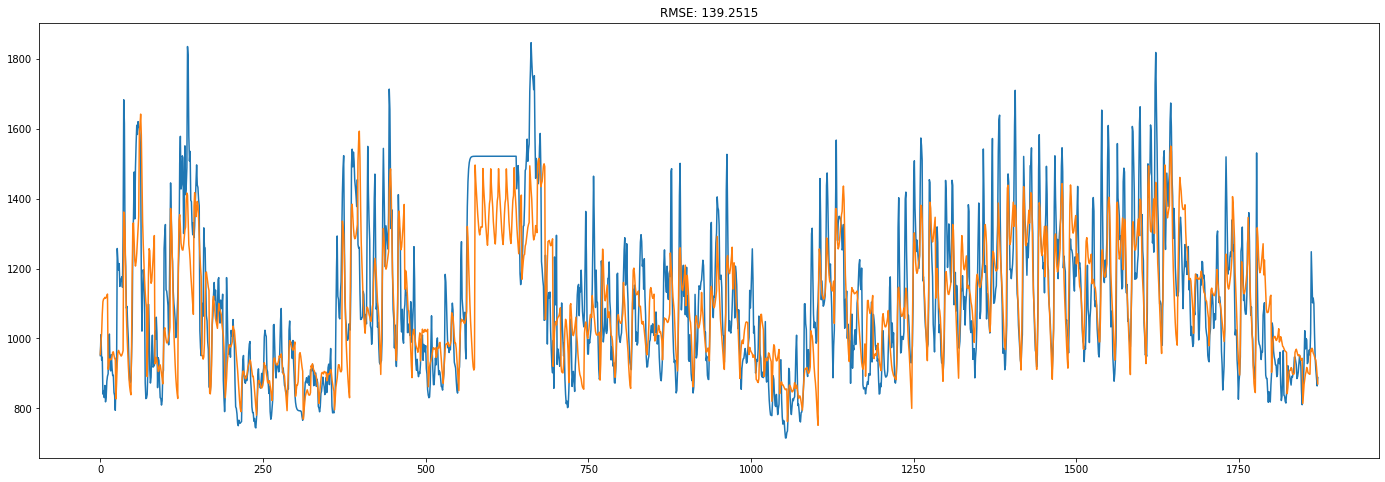

In [122]:
index = range(len(plot_ground_truth))
plt.figure(facecolor = 'white',figsize = (24,8))
plt.plot(index,plot_ground_truth,label = 'Ground_truth')
plt.plot(index,plot_predictions,label = 'Prediction')
plt.title('RMSE: %.4f'% score)
plt.show()

Residual analysis, it seems like white noise,which prove no valuable information can be extract.

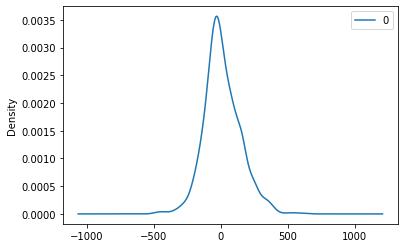

In [123]:
residual = pd.DataFrame(residual)
residual.plot.density(label = 'residual')
plt.show()

In [124]:
from scipy.stats import anderson
anderson (residual.values, dist ='norm')

AndersonResult(statistic=array([-1870.00523625, -1866.01570875, -1862.02618126, ...,
        5586.42165738,  5590.41118488,  5594.40071238]), critical_values=array([0.575, 0.655, 0.785, 0.916, 1.09 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

The prediction of first order difference data is here, it seems not very good                                         
And I tried in/out_put size as 1,3,6,12                                                                   
RMSE is around 96.68,136.61,188.42,136.67.                                                                 Of course,with smaller time_step, prediction can be corrected in time, but it seems network learn more with time_step = 12 which have a less RMSE
![jupyter](./With_diff(1).png)